In [1]:
#!jupyter nbconvert --to script 1-preprocessing.ipynb

In [2]:
from collections import defaultdict
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

pd.set_option('display.max_columns', None)

In [3]:
drop_initially = ['pais_residencia', 'fecha_alta', 'ult_fec_cli_1t', 'conyuemp',
                  'canal_entrada', 'indfall', 'tipodom', 'nomprov']

In [4]:
import warnings

# Disable typecast warnings
warnings.filterwarnings('ignore')

na_values=['NA', 'nan']

dtype = {'tiprel_1mes':np.str, 'indrel_1mes':np.str, 'fecha_dato':np.str, 'ult_fec_cli_1t':np.str}

iter_csv = pd.read_csv('../data/raw/train.csv.zip', na_values = na_values, skipinitialspace = True, 
                       iterator=True, chunksize=100000, dtype=dtype)

df = pd.concat([chunk for chunk in iter_csv], ignore_index=True)
df.drop(drop_initially, axis=1, inplace=True)

In [5]:
df.head()

,fecha_dato,ncodpers,ind_empleado,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,indresi,indext,cod_prov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,H,35.0,0.0,6.0,1.0,1.0,A,S,N,29.0,1.0,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,V,23.0,0.0,35.0,1.0,1,I,S,S,13.0,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,V,23.0,0.0,35.0,1.0,1,I,S,N,13.0,0.0,122179.11,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,H,22.0,0.0,35.0,1.0,1,I,S,N,50.0,0.0,119775.54,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,V,23.0,0.0,35.0,1.0,1,A,S,N,50.0,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


In [6]:
na_values=['NA', 'nan']
dtype = {'tiprel_1mes':np.str, 'indrel_1mes':np.str, 'fecha_dato':np.str}

iter_csv = pd.read_csv('../data/raw/test.csv.zip', na_values = na_values, skipinitialspace = True, 
                       iterator=True, chunksize=100000, dtype=dtype)

test = pd.concat([chunk for chunk in iter_csv], ignore_index=True)
test.drop(drop_initially, axis=1, inplace=True)

In [7]:
test.head()

,fecha_dato,ncodpers,ind_empleado,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,indresi,indext,cod_prov,ind_actividad_cliente,renta,segmento
0,2016-06-28,15889,F,V,56,0,256,1,1,A,S,N,28.0,1,326124.90,01 - TOP
1,2016-06-28,1170544,N,H,36,0,34,1,1,I,S,N,3.0,0,NaN,02 - PARTICULARES
2,2016-06-28,1170545,N,V,22,0,34,1,1,A,S,N,15.0,1,NaN,03 - UNIVERSITARIO
3,2016-06-28,1170547,N,H,22,0,34,1,1,I,S,N,8.0,0,148402.98,03 - UNIVERSITARIO
4,2016-06-28,1170548,N,H,22,0,34,1,1,I,S,N,7.0,0,106885.80,03 - UNIVERSITARIO


In [8]:
products = ['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
            'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
            'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
            'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
            'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
            'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
            'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
            'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1']

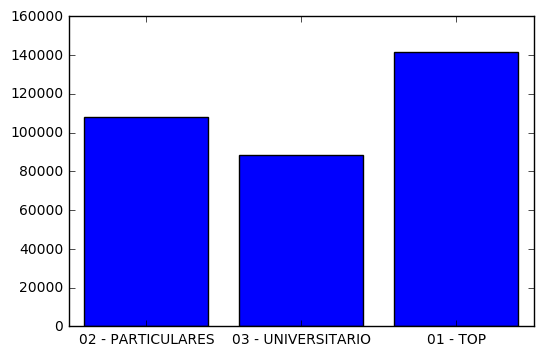

In [9]:
# Median income per segmento
segm_rent = defaultdict(set)
df.groupby(['segmento']).apply(lambda x: segm_rent[x.segmento.values[0]].add(x.renta.median()))

keys = []
vals = []

for k, v in segm_rent.items():
    keys.append(k)
    vals.append(list(v)[0])
    
fig, ax = plt.subplots()
ind = np.arange(len(keys))  # the x locations for the groups

ax.bar(ind, vals, align='center')
ax.set_xticks(ind)
ax.set_xticklabels(keys)
plt.show()

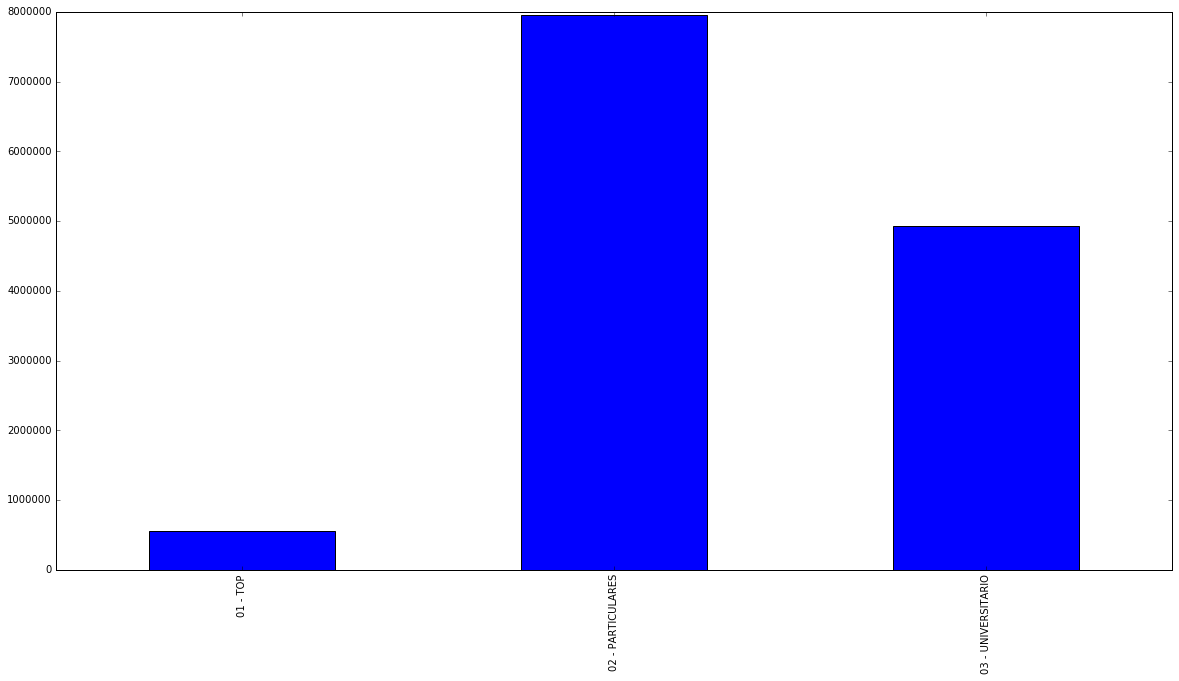

In [30]:
# Segmento distribution
pd.value_counts(df.segmento).sort_index().plot(kind="bar", figsize=(20,10))

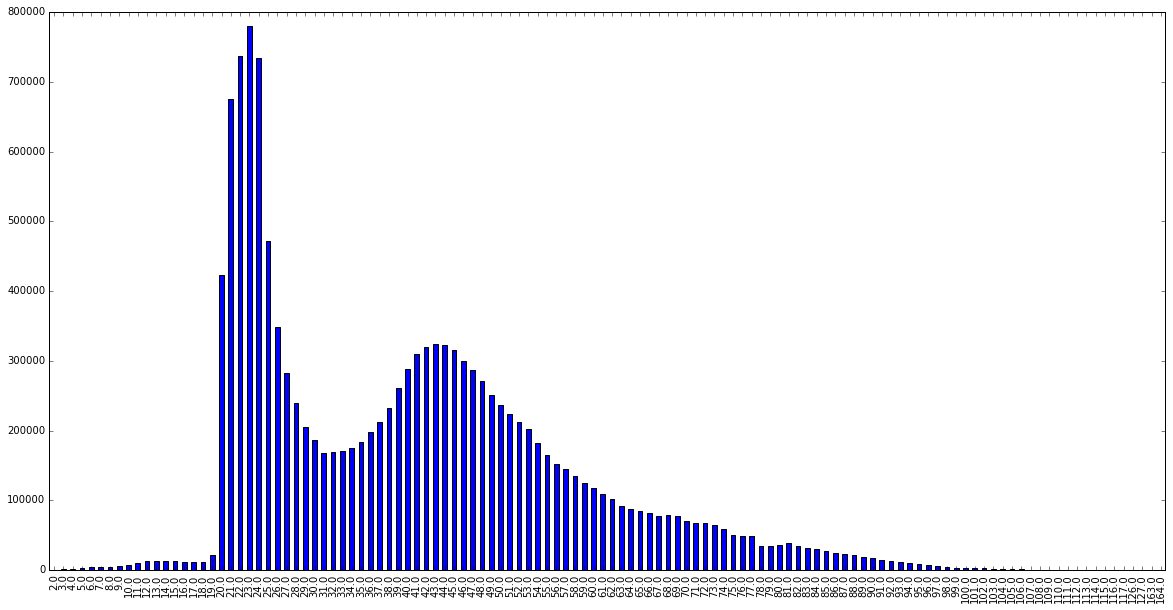

In [27]:
# Age distribution
pd.value_counts(df.age).sort_index().plot(kind="bar", figsize=(20,10))

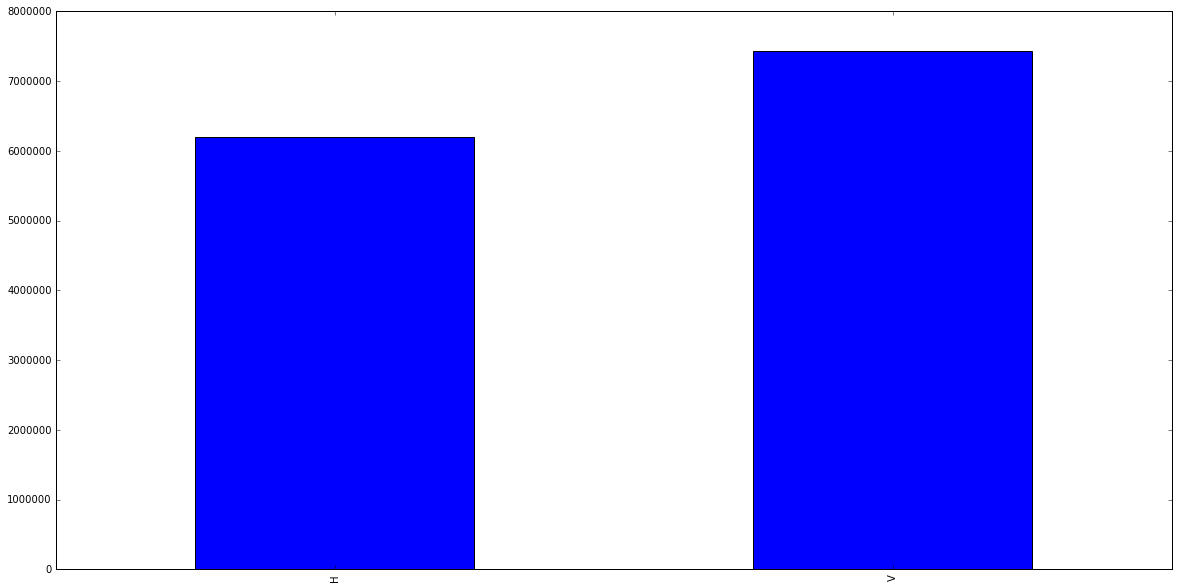

In [28]:
#Sex distribution
pd.value_counts(df.sexo).sort_index().plot(kind="bar", figsize=(20,10))

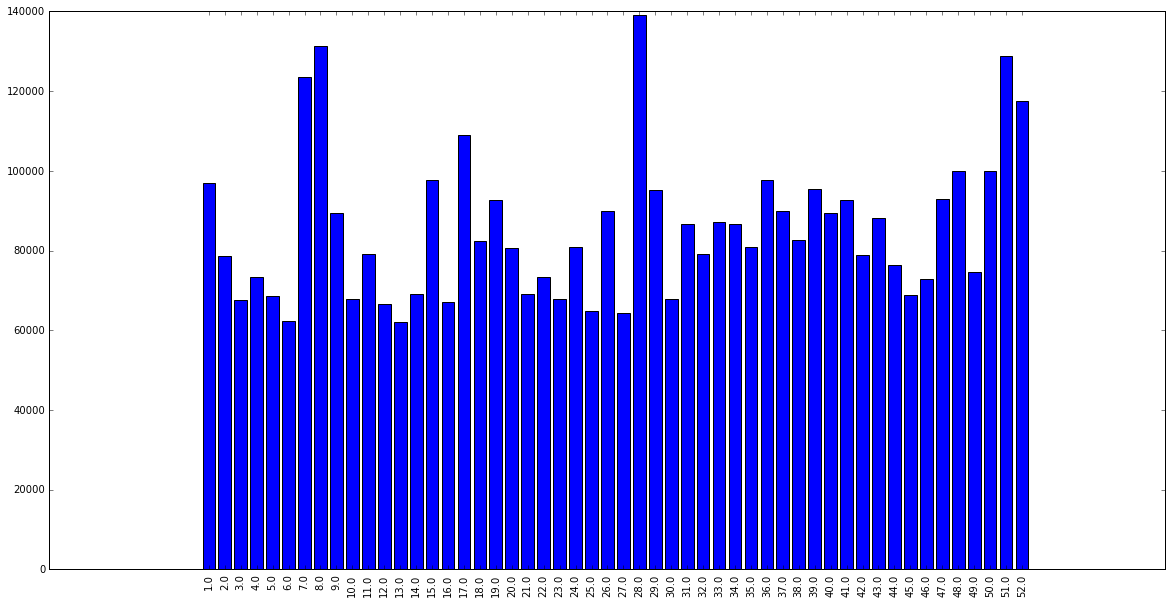

In [29]:
# Income distribution per state
prov_rent = defaultdict(set)
df.groupby(['cod_prov']).apply(lambda x: prov_rent[x.cod_prov.values[0]].add(x.renta.median()))

keys = []
vals = []

for k, v in prov_rent.items():
    keys.append(k)
    vals.append(list(v)[0])
    
fig, ax = plt.subplots(figsize=(20, 10))
ind = np.arange(len(keys))  # the x locations for the groups

ax.bar(ind, vals, align='center')
ax.set_xticks(ind)
ax.set_xticklabels(keys, rotation='vertical')
plt.show()

In [11]:
renta_quantiles = df.groupby(["cod_prov"]).agg({"renta": { "20" :     lambda x: x[x.notnull()].quantile(0.2),
                                                           "40" :     lambda x: x[x.notnull()].quantile(0.4),
                                                           "60" :     lambda x: x[x.notnull()].quantile(0.6),
                                                           "80" :     lambda x: x[x.notnull()].quantile(0.8),
                                                           "median" : lambda x: x.median(skipna=True),
                                                           "mean" :   lambda x: x.mean(skipna=True)}
                                                })

renta_quantiles = renta_quantiles['renta'][['20','40','60','80', 'median', 'mean']]

In [12]:
renta_quantiles.head()

,20,40,60,80,median,mean
cod_prov,,,,,,
1.0,55271.07,74453.79,97281.198,164007.12,96967.65,111098.148000
2.0,52893.36,71157.93,86379.360,108267.33,78657.30,83064.848288
3.0,42167.28,57949.53,78608.250,112338.96,67526.28,87357.524678
4.0,50148.75,65699.34,82289.610,108253.35,73390.65,85400.890251
5.0,48066.54,61396.98,76591.200,97417.56,68561.28,76853.644825


In [13]:
df = df[df.age.notnull() & df.sexo.notnull() & df.fecha_dato.isin(['2015-05-28', '2015-06-28', '2016-05-28', '2016-06-28'])]
df.sort_values(['ncodpers', 'fecha_dato'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [14]:
df.head()

,fecha_dato,ncodpers,ind_empleado,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,indresi,indext,cod_prov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-05-28,15889,F,V,56.0,0.0,245.0,1.0,1,A,S,N,28.0,1.0,326124.9,01 - TOP,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0.0,0.0,0
1,2015-06-28,15889,F,V,56.0,0.0,245.0,1.0,1,A,S,N,28.0,1.0,326124.9,01 - TOP,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0.0,0.0,0
2,2016-05-28,15889,F,V,56.0,0.0,255.0,1.0,1,A,S,N,28.0,1.0,326124.9,01 - TOP,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0.0,0.0,0
3,2015-05-28,15890,A,V,62.0,0.0,246.0,1.0,1,A,S,N,28.0,1.0,71461.2,02 - PARTICULARES,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1.0,1.0,1
4,2015-06-28,15890,A,V,62.0,0.0,246.0,1.0,1,A,S,N,28.0,1.0,71461.2,02 - PARTICULARES,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1.0,1.0,1


In [15]:
for cod_prov, row in renta_quantiles.iterrows():
    result = df.loc[(df.cod_prov == cod_prov), 'renta'].apply(lambda x: np.nan if np.isnan(x) else 0 if x<=row['20'] else 1 if x<=row['40'] else 2 if x<=row['60'] else 3 if x<=row['80'] else 4)
    df.loc[(df.cod_prov == cod_prov), 'renta'] = result
    
    result = test.loc[(test.cod_prov == cod_prov), 'renta'].apply(lambda x: np.nan if np.isnan(x) else 0 if x<=row['20'] else 1 if x<=row['40'] else 2 if x<=row['60'] else 3 if x<=row['80'] else 4)
    test.loc[(test.cod_prov == cod_prov), 'renta'] = result

result = df.age.apply(lambda x: np.nan if np.isnan(x) else 0 if x<25 else 1 if x<31 else 2 if x<41 else 3 if x<61 else 4)
df.age = result
    
result = test.age.apply(lambda x: np.nan if np.isnan(x) else 0 if x<25 else 1 if x<31 else 2 if x<41 else 3 if x<61 else 4)
test.age = result

In [16]:
df.head()

,fecha_dato,ncodpers,ind_empleado,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,indresi,indext,cod_prov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-05-28,15889,F,V,3,0.0,245.0,1.0,1,A,S,N,28.0,1.0,4.0,01 - TOP,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0.0,0.0,0
1,2015-06-28,15889,F,V,3,0.0,245.0,1.0,1,A,S,N,28.0,1.0,4.0,01 - TOP,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0.0,0.0,0
2,2016-05-28,15889,F,V,3,0.0,255.0,1.0,1,A,S,N,28.0,1.0,4.0,01 - TOP,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0.0,0.0,0
3,2015-05-28,15890,A,V,4,0.0,246.0,1.0,1,A,S,N,28.0,1.0,0.0,02 - PARTICULARES,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1.0,1.0,1
4,2015-06-28,15890,A,V,4,0.0,246.0,1.0,1,A,S,N,28.0,1.0,0.0,02 - PARTICULARES,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1.0,1.0,1


In [17]:
test.head()

,fecha_dato,ncodpers,ind_empleado,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,indresi,indext,cod_prov,ind_actividad_cliente,renta,segmento
0,2016-06-28,15889,F,V,3,0,256,1,1,A,S,N,28.0,1,4.0,01 - TOP
1,2016-06-28,1170544,N,H,2,0,34,1,1,I,S,N,3.0,0,NaN,02 - PARTICULARES
2,2016-06-28,1170545,N,V,0,0,34,1,1,A,S,N,15.0,1,NaN,03 - UNIVERSITARIO
3,2016-06-28,1170547,N,H,0,0,34,1,1,I,S,N,8.0,0,2.0,03 - UNIVERSITARIO
4,2016-06-28,1170548,N,H,0,0,34,1,1,I,S,N,7.0,0,1.0,03 - UNIVERSITARIO


In [18]:
def preprocess_features(X):        

    # sexo
    X.sexo.replace(to_replace=['V', 'H'], value=[1.0, 0.0], inplace=True)
    X.sexo = pd.to_numeric(X.sexo, errors='raise')
    
    # ind_empleado
    X.ind_empleado.replace(to_replace=['A', 'B', 'F', 'N', 'P', 'S'], value=[4, 1, 3, 0, 2, np.nan], inplace=True)
    X.ind_empleado = pd.to_numeric(X.ind_empleado, errors='raise')
    
    # ind_nuevo
    X.loc[(X.ind_nuevo.isnull()) & (X.antiguedad < 6), 'ind_nuevo'] = 1
    X.loc[(X.ind_nuevo.isnull()) & (X.antiguedad >= 6), 'ind_nuevo'] = 0 
    X.ind_nuevo = pd.to_numeric(X.ind_nuevo, errors='raise')
    
    
    # indrel
    X.indrel.replace(to_replace=[99.], value=[0.], inplace=True)  
    X.indrel = pd.to_numeric(X.indrel, errors='raise')
    
    # cod_prov
    X.cod_prov.replace(to_replace=np.arange(1,53,1), value=np.argsort(renta_quantiles.loc[:, 'mean'].values), inplace=True)
    X.cod_prov = pd.to_numeric(X.cod_prov, errors='raise')
    
    # indrel_1mes
    X.indrel_1mes.replace(to_replace=['1', '2', 'P', '3', '4'], value=[0,1,2,3,4], inplace=True)
    X.indrel_1mes = pd.to_numeric(X.indrel_1mes, errors='raise')
    
    # tiprel_1mes
    X.tiprel_1mes.replace(to_replace=['A', 'R', 'I', 'P'], value=[0,1,2,3], inplace=True)
    X.tiprel_1mes = pd.to_numeric(X.tiprel_1mes, errors='raise')
    
    # indresi
    X.indresi.replace(to_replace=['S', 'N'], value=[1.0, 0.0], inplace=True) 
    X.indresi = pd.to_numeric(X.indresi, errors='raise')
    
    # indext
    X.indext.replace(to_replace=['S', 'N'], value=[1.0, 0.0], inplace=True) 
    X.indext = pd.to_numeric(X.indext, errors='raise')

    # segmento
    X.segmento.replace(to_replace=['01 - TOP', '02 - PARTICULARES', '03 - UNIVERSITARIO'], value=[0, 1, 2], inplace=True) 
    X.segmento = pd.to_numeric(X.segmento, errors='raise')
    
    return X

In [19]:
df = preprocess_features(df)
df.loc[df.ind_nomina_ult1.isnull(), 'ind_nomina_ult1'] = 0 
df.loc[df.ind_nom_pens_ult1.isnull(), 'ind_nom_pens_ult1'] = 0

test = preprocess_features(test)

In [20]:
test.head()

,fecha_dato,ncodpers,ind_empleado,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,indresi,indext,cod_prov,ind_actividad_cliente,renta,segmento
0,2016-06-28,15889,3.0,1.0,3,0,256,1,0.0,0.0,1.0,0.0,39.0,1,4.0,0.0
1,2016-06-28,1170544,0.0,0.0,2,0,34,1,0.0,2.0,1.0,0.0,5.0,0,NaN,1.0
2,2016-06-28,1170545,0.0,1.0,0,0,34,1,0.0,0.0,1.0,0.0,48.0,1,NaN,2.0
3,2016-06-28,1170547,0.0,0.0,0,0,34,1,0.0,2.0,1.0,0.0,22.0,0,2.0,2.0
4,2016-06-28,1170548,0.0,0.0,0,0,34,1,0.0,2.0,1.0,0.0,4.0,0,1.0,2.0


In [21]:
df.head()

,fecha_dato,ncodpers,ind_empleado,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,indresi,indext,cod_prov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-05-28,15889,3.0,1.0,3,0.0,245.0,1.0,0.0,0.0,1.0,0.0,39.0,1.0,4.0,0.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0.0,0.0,0
1,2015-06-28,15889,3.0,1.0,3,0.0,245.0,1.0,0.0,0.0,1.0,0.0,39.0,1.0,4.0,0.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0.0,0.0,0
2,2016-05-28,15889,3.0,1.0,3,0.0,255.0,1.0,0.0,0.0,1.0,0.0,39.0,1.0,4.0,0.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0.0,0.0,0
3,2015-05-28,15890,4.0,1.0,4,0.0,246.0,1.0,0.0,0.0,1.0,0.0,39.0,1.0,0.0,1.0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1.0,1.0,1
4,2015-06-28,15890,4.0,1.0,4,0.0,246.0,1.0,0.0,0.0,1.0,0.0,39.0,1.0,0.0,1.0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1.0,1.0,1


In [22]:
# Check that we don't lose anything
print("Feature set of test and train sets are equal:", set(test.columns) == set(set(df.columns) - set(products)))

Feature set of test and train sets are equal: True


In [23]:
df.to_csv('../data/processed/train-processed.csv.gz', index=False, compression='gzip')

In [24]:
test.to_csv('../data/processed/test-processed.csv.gz', index=False, compression='gzip')